In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = True

function_folder = "seq_sin_pink_-3.32"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

           0         1         2         3         4         5         6  \
0  -1.071127 -1.450996 -2.636308 -0.329549  1.806948  1.296416 -0.135281   
1  -0.170276 -0.301575 -0.597102 -1.104663 -1.364563 -0.074106  0.991372   
2   0.572085  0.566875 -1.531421 -1.273426  0.067433 -1.421599  0.149881   
3   0.192757 -1.025377  0.187920 -0.748283 -0.556933  2.589141  1.456760   
4   0.760082  0.611429  0.951301  0.966506 -2.485724 -1.879708 -0.030122   
..       ...       ...       ...       ...       ...       ...       ...   
65 -0.564578  0.900035  2.013946 -1.208904  0.709127 -0.188264  0.551594   
66 -0.116741 -0.586607 -1.699672 -1.413316 -0.153026 -0.177135  0.802231   
67  0.873958 -0.945411 -1.499962 -1.318186 -0.230880  1.294361 -0.392952   
68  1.294384  0.157060 -0.481691 -1.494932 -0.351063  0.130868  0.154464   
69 -1.020470 -0.851054 -1.218941 -1.762148 -1.213100 -0.331554  1.601328   

           7         8         9  ...        20        21        22        23  \
0   2.

In [3]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [4]:
tensors['test'][1].shape

torch.Size([20, 30])

# Evaluate KAN

In [5]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 10, input_size], [input_size, 5, input_size], [input_size, 4, input_size], [input_size, 3, input_size], [input_size, 2, input_size]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [1]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


| train_loss: 1.73e-01 | test_loss: 8.86e-01 | reg: 2.88e+01 | : 100%|█| 1/1 [00:00<00:00,  1.04it/s

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 1, 'kan__grid': 3, 'kan__k': 5, 'kan__lamb': 0, 'kan__lr': 0.001, 'kan__seed': 42, 'kan__width': [30, 2, 30]}
Best Cross-Validation Score: -0.2212340958416462


In [6]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=10)
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.16e-04 | test_loss: 1.78e-02 | reg: 1.10e+01 | : 100%|█| 10/10 [00:02<00:00,  3.77it

saving model version 0.1


In [7]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [8]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


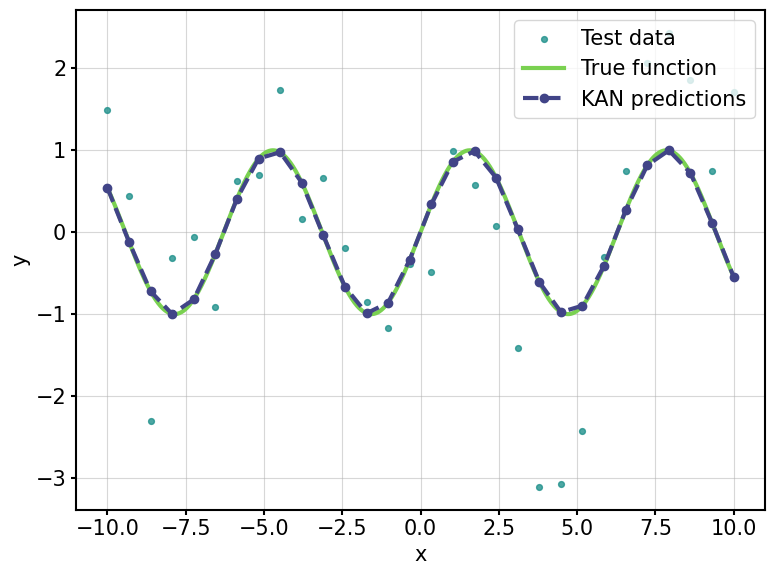

In [9]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [10]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [11]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [12]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

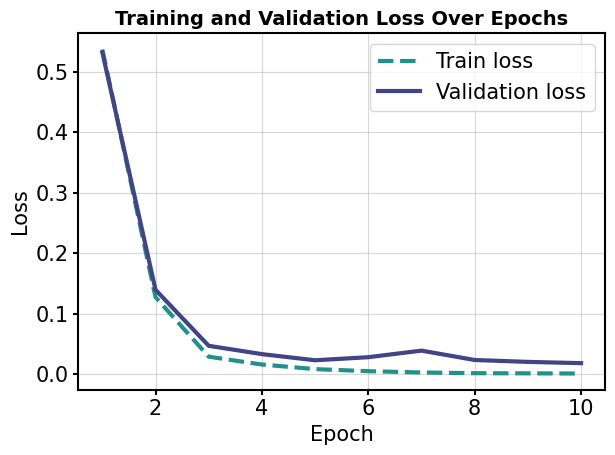

In [13]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [14]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [20],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)"""

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\madel\5.1 Project Course in DS\KAN_Git\KAN-Kolmogorov-Arnold-Networks\MLP\MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
100%|██████████| 20/20 [00:00<00:00, 66.44it/s]

Best Parameters: {'mlp__data': [], 'mlp__deepmimo': True, 'mlp__epochs': 20, 'mlp__hidden_size': [2000], 'mlp__input_size': 30, 'mlp__output_size': 30}
Best Cross-Validation Score: -0.00015911868763515802


In [15]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


torch.Size([30])
30


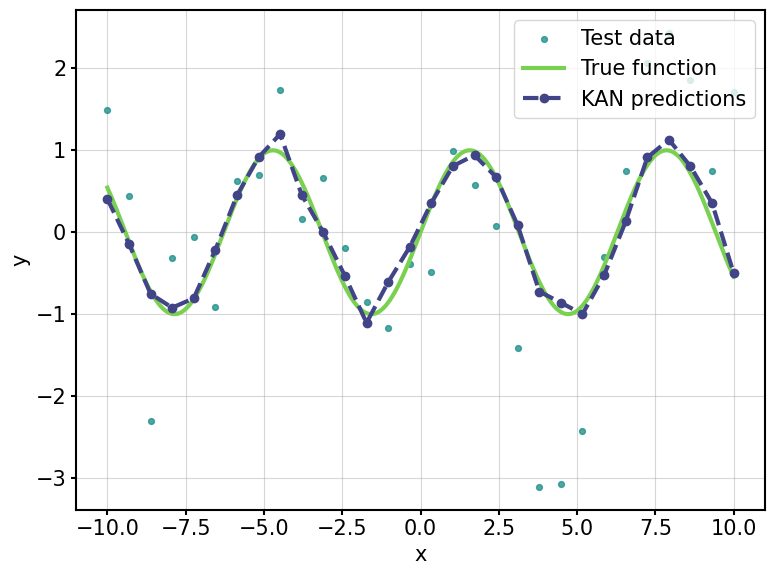

In [16]:
# plot predictions
if deepmimo:
    # mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

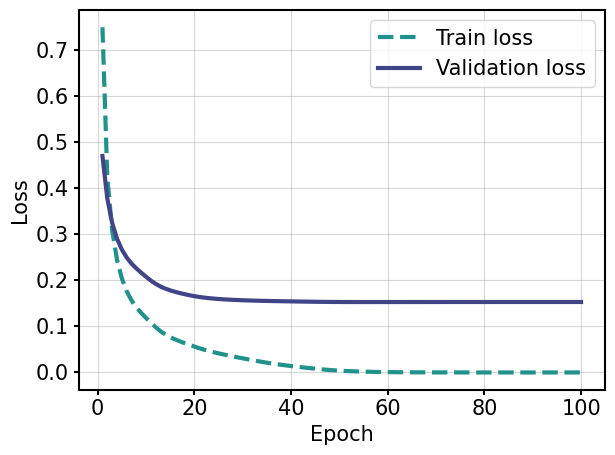

In [17]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)